# Demonstration Usage Fitting Procedures

In [ ]:
# Import FittingProcedures
from FittingProcedures import *
import numpy as np
import matplotlib.pyplot as plt


In [4]:
def PlotDistributionAndFit(x,y,x_fit,y_fit,label_fit,StrFunction):
    fig, ax = plt.subplots()
    ax.plot(x, y, 'b-', label='data')
    ax.plot(x_fit, y_fit, 'r-', label=label_fit)
    ax.set_title(StrFunction)
    ax.legend(loc='best')
    plt.show()



# PL and EXPO

In [ ]:
import numpy as np
from FittingProcedures import *

seed = np.random.seed(122)
# Gaussian Noise
mean = 0
std = 10
# Length Distribution
N = 100
Methods2SuccsessPl = {method:0 for method in ["Nelder-Mead","Powell","CG","BFGS","L-BFGS-B","TNC","COBYLA","SLSQP","trust-constr","dogleg","trust-ncg","trust-exact","trust-krylov"]}
Methods2SuccessExp = {method:0 for method in ["Nelder-Mead","Powell","CG","BFGS","L-BFGS-B","TNC","COBYLA","SLSQP","trust-constr","dogleg","trust-ncg","trust-exact","trust-krylov"]}

for i in range(100):
    gaussian_noise = np.random.normal(mean,std,N)
    time_ = np.linspace(0,50,100)
    #
    Amin = 0
    Amax = 1000
    A = np.random.uniform(Amin,Amax)
    t0min = -5
    t0max = 5
    t0 = np.random.uniform(t0min,t0max)
    # Exponential Decay + Noise
    exp_t = A*np.exp(time_*t0) + gaussian_noise
    # Power Law Decay + Noise
    plaw_t = A*time_**t0 + gaussian_noise
    # Construction Integral
    dt = np.diff(time_) 
    # Normalization
    Z_exp = np.sum(exp_t[:-1]*dt)
    Z_plaw = np.sum(plaw_t[1:-1]*dt[1:])
    logger.info(f"A: {A}, t0: {t0}")
    for method in ["Nelder-Mead","Powell","CG","BFGS","L-BFGS-B","TNC","COBYLA","SLSQP"]:
        try:
            fit,StdError,ConvergenceSuccess,y_fit,x,y_measured = FitAndStdErrorFromXY(time_,plaw_t,"powerlaw",(1,-1),maxfev = 100000,interval = [],method = method)
            if ConvergenceSuccess:
                Methods2SuccsessPl[method] += 1
            A_pl,t0_pl = fit[0]
            fit,StdError,ConvergenceSuccess,y_fit,x,y_measured = FitAndStdErrorFromXY(time_,exp_t,"exponential",(1,-1),maxfev = 100000,interval = [],method = method)
            PlotDistributionAndFit(time_,exp_t,time_,y_fit,"exponential",method)
            if ConvergenceSuccess:
                Methods2SuccessExp[method] += 1
            A_exp,t0_exp = fit[0]
        except:
#            print(f"Method {method} failed")
            pass
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.bar(Methods2SuccessExp.keys(),Methods2SuccessExp.values(),label = "Exponential")
ax.set_xticklabels(Methods2SuccessExp.keys(),rotation = 90)



# Fit Gauss

In [ ]:
seed = np.random.seed(122)
# Gaussian Noise
mean = 0
std = 10
# Length Distribution
N = 100
Methods2SuccsessPl = {method:0 for method in ["Nelder-Mead","Powell","CG","BFGS","L-BFGS-B","TNC","COBYLA","SLSQP","trust-constr","dogleg","trust-ncg","trust-exact","trust-krylov"]}
Methods2SuccessExp = {method:0 for method in ["Nelder-Mead","Powell","CG","BFGS","L-BFGS-B","TNC","COBYLA","SLSQP","trust-constr","dogleg","trust-ncg","trust-exact","trust-krylov"]}

for i in range(100):
    gaussian_noise = np.random.normal(mean,std,N)
    time_ = np.linspace(0,50,100)
    #
    Amin = 0
    Amax = 1000
    A = np.random.uniform(Amin,Amax)
    t0min = -5
    t0max = 5
    t0 = np.random.uniform(t0min,t0max)
    # Exponential Decay + Noise
    gauss_t = A*np.exp((time_-mu_t)**2*t0) + gaussian_noise
    # Power Law Decay + Noise
    plaw_t = A*time_**t0 + gaussian_noise
    # Construction Integral
    dt = np.diff(time_) 
    # Normalization
    Z_exp = np.sum(exp_t[:-1]*dt)
    Z_plaw = np.sum(plaw_t[1:-1]*dt[1:])
    logger.info(f"A: {A}, t0: {t0}")
    for method in ["Nelder-Mead","Powell","CG","BFGS","L-BFGS-B","TNC","COBYLA","SLSQP"]:
        try:
            fit,StdError,ConvergenceSuccess,y_fit,x,y_measured = FitAndStdErrorFromXY(time_,plaw_t,"powerlaw",(1,-1),maxfev = 100000,interval = [],method = method)
            if ConvergenceSuccess:
                Methods2SuccsessPl[method] += 1
            A_pl,t0_pl = fit[0]
            fit,StdError,ConvergenceSuccess,y_fit,x,y_measured = FitAndStdErrorFromXY(time_,exp_t,"exponential",(1,-1),maxfev = 100000,interval = [],method = method)
            PlotDistributionAndFit(time_,exp_t,time_,y_fit,"exponential",method)
            if ConvergenceSuccess:
                Methods2SuccessExp[method] += 1
            A_exp,t0_exp = fit[0]
        except:
#            print(f"Method {method} failed")
            pass
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.bar(Methods2SuccessExp.keys(),Methods2SuccessExp.values(),label = "Exponential")
ax.set_xticklabels(Methods2SuccessExp.keys(),rotation = 90)


# GRAVITY MODEL FIT

In [ ]:
N_grids = 400
# Range Parameters
k_min = 0.1
k_max = 100000
# PL mi
alpha_min = -3
alpha_max = 3
# PL mj
gamma_min = -3
gamma_max = 3
# PL d0
d0_min = 0.0001
d0_max = 1
k = np.random.uniform(k_min,k_max)
alpha = np.random.uniform(alpha_min,alpha_max)
gamma = np.random.uniform(gamma_min,gamma_max)
d0 = np.random.uniform(d0_min,d0_max)
dij = np.random.uniform(d0, N_grids**2)
mi = np.random.exponential(d0, N_grids)
mi_alpha = mi**alpha
mj = mi
mj_gamma = mj**gamma
MiMj = np.meshgrid(mi,mj).reshape(N_grids**2)
Tij = k*MiMj/np.exp(dij*d0)
fit,StdError,ConvergenceSuccess,y_fit,x,y_measured = FitAndStdErrorFromXY(Tij,np.array([mi,mj,dij]),"powerlaw",(1,-1),maxfev = 100000,interval = [],method = method)



{'Nelder-Mead': 0,
 'Powell': 0,
 'CG': 0,
 'BFGS': 0,
 'L-BFGS-B': 0,
 'TNC': 0,
 'COBYLA': 0,
 'SLSQP': 0,
 'trust-constr': 0,
 'dogleg': 0,
 'trust-ncg': 0,
 'trust-exact': 0,
 'trust-krylov': 0}

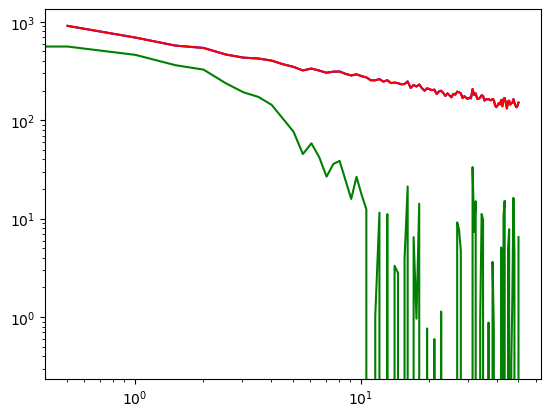

In [18]:
mask = np.logical_and(np.array(time_) > 0, np.array(plaw_t) > 0)
x = time_[mask]
y_measured = plaw_t[mask]

fig,ax = plt.subplots()
ax.plot(x,y_measured,"b-")
ax.plot(time_,plaw_t,"r-")
ax.plot(time_,exp_t,"g-")
ax.set_xscale("log")
ax.set_yscale("log")

In [5]:
import pytensor
import pytensor.tensor as pt
from pytensor.graph.op import Op
import numpy as np
Name2DataAndParameters ={"a":1,"b":2,"x":np.array([1,2,3,4,5])}
lambda x,a,b: a*np.exp(-b*x)
class BestFit(Op):
        def make_node(self,Name2DataAndParameters):
            for Name,DataOrPar in Name2DataAndParameters.items():
                DataOrPar = pt.as_tensor(DataOrPar,Name)
                DataOrPar.dprint()
                print(DataOrPar.owner)
        def perform(self,inputs,outputs,function):
            
            pass
bf = BestFit()
bf.make_node(Name2DataAndParameters)
bf.perform([],[],lambda x,a,b: a*np.exp(-b*x))

a{1} [id A]
None
b{2} [id A]
None
x{[1 2 3 4 5]} [id A]
None
